In [1]:
import RPi.GPIO as GPIO
import gpiozero
import time
import numpy as np
from matplotlib import pyplot as plt


In [2]:
# Constants
# Encoder pins
# ML = motor left, MR = motor right
GPIO.cleanup()
GPIO.setmode(GPIO.BCM)

ML_ENC_A = 23 # yellow encoder c 
ML_ENC_B = 24 # white encoder c

MR_ENC_A = 14 # yellow encoder c
MR_ENC_B = 15 # white encoder c

"""
- gear ratio = 75:1 = motor shaft rotates 75 times each revolution
- encoder = 48 CPR (count per revolution) = 48 counts each shaft rotation
- counts per round = count per rev * rev per round = 48*75 = 3600
"""
MAX_ENC_STEPS = 3600

# Motor Pins
ML_IN1 = 10 # IN1 
ML_IN2 = 22 # IN2
ML_ENA = 9 # brown

MR_IN3 = 27 # IN3
MR_IN4 = 17 # IN4
MR_ENB = 11

# Physical dimensions
WHEEL_RADIUS = 0.056 # meters
WHEEL_SEP = 0.222 # meters


/tmp/ipykernel_2527/1274623490.py:4: RuntimeWarning: No channels have been set up yet - nothing to clean up!  Try cleaning up at the end of your program instead!
  GPIO.cleanup()


In [3]:

# wheel separation measurement (ASCII art)
"""
    <------- l ------->
    |                 |
 ___|___           ___|___
|       |         |       |
|   O   |         |   O   |
|_______|         |_______|
    ^                 ^
    |                 |
  Left wheel       Right wheel
  center            center
"""

class DiffDriveRobot:
    def __init__(
            self, 
            dt=0.1, 
            wheel_radius=WHEEL_RADIUS, 
            wheel_sep=WHEEL_SEP,
            max_enc_steps=MAX_ENC_STEPS,
            ml_pwm=ML_ENA,
            mr_pwm=MR_ENB,
            ml_in1=ML_IN1,
            ml_in2=ML_IN2,
            mr_in3=MR_IN3,
            mr_in4=MR_IN4,
            ml_encA=ML_ENC_A,
            ml_encB=ML_ENC_B,
            mr_encA=MR_ENC_A,
            mr_encB=MR_ENC_B
    ):
        self.x = 0.0  # x-position
        self.y = 0.0  # y-position 
        self.th = 0.0  # orientation
        
        self.wl = 0.0  # rotational velocity left wheel
        self.wr = 0.0  # rotational velocity right wheel
        
        self.dt = dt # time delta in seconds
        self.r = wheel_radius # wheel radius in meters
        self.l = wheel_sep # wheel separation in meters
        self.max_enc_steps = max_enc_steps # steps in the encoder per revolution
        
        # Pin numbers
        self.motor_L_in1 = ml_in1 # Input 1 (motor left)
        self.motor_L_in2 = ml_in2 # Input 2 (motor left)
        self.motor_R_in3 = mr_in3 # Input 3 (motor right)
        self.motor_R_in4 = mr_in4 # Input 4 (motor right)
        GPIO.setup(self.motor_L_in1, GPIO.OUT)
        GPIO.setup(self.motor_L_in2, GPIO.OUT)
        GPIO.setup(self.motor_R_in3, GPIO.OUT)
        GPIO.setup(self.motor_R_in4, GPIO.OUT)      
        
        # Initialize encoders
        self.ML_ENC = gpiozero.RotaryEncoder(a=ml_encA, b=ml_encB, max_steps=max_enc_steps, wrap=True)
        self.MR_ENC = gpiozero.RotaryEncoder(a=mr_encA, b=mr_encB, max_steps=max_enc_steps, wrap=True)
        self.ml_enc_steps = 0 # left motor encoder value (AKA shaft angle) in steps. 
        self.mr_enc_steps = 0 # right motor encoder value (AKA shaft angle) in steps. 

        # Initialize motor control pins
        GPIO.setup(ml_pwm, GPIO.OUT)
        GPIO.setup(mr_pwm, GPIO.OUT)
        self.motor_L_pwm = GPIO.PWM(ml_pwm, 1000)  # 1000 Hz frequency
        self.motor_R_pwm = GPIO.PWM(mr_pwm, 1000)
        self.motor_L_pwm.start(0)
        self.motor_R_pwm.start(0)
        

    def read_wheel_velocities(self):
        ml_enc_now = self.ML_ENC.steps
        mr_enc_now = self.MR_ENC.steps

        # Calculate change in steps, accounting for wrap-around
        ml_enc_delta = (ml_enc_now - self.ml_enc_steps + self.max_enc_steps) % (2 * self.max_enc_steps) - self.max_enc_steps
        mr_enc_delta = (mr_enc_now - self.mr_enc_steps + self.max_enc_steps) % (2 * self.max_enc_steps) - self.max_enc_steps
        
        # Convert step change to radians
        ml_delta_rad = ml_enc_delta / self.max_enc_steps * 2 * np.pi
        mr_delta_rad = mr_enc_delta / self.max_enc_steps * 2 * np.pi

        # Calculate velocities
        self.wl = ml_delta_rad / self.dt
        self.wr = mr_delta_rad / self.dt

        # Update previous steps
        self.ml_enc_steps = ml_enc_now
        self.mr_enc_steps = mr_enc_now

        return self.wl, self.wr
  

    def set_motor_speed(self, left_duty_cycle, right_duty_cycle):
        # Set direction
        GPIO.output(self.motor_L_in1, GPIO.HIGH if left_duty_cycle >= 0 else GPIO.LOW)
        GPIO.output(self.motor_L_in2, GPIO.LOW if left_duty_cycle >= 0 else GPIO.HIGH)
        GPIO.output(self.motor_R_in3, GPIO.HIGH if right_duty_cycle >= 0 else GPIO.LOW)
        GPIO.output(self.motor_R_in4, GPIO.LOW if right_duty_cycle >= 0 else GPIO.HIGH)

        # Set speed
        self.motor_L_pwm.ChangeDutyCycle(abs(left_duty_cycle) * 100)
        self.motor_R_pwm.ChangeDutyCycle(abs(right_duty_cycle) * 100)

    def base_velocity(self, wl, wr):
        v = (wl * self.r + wr * self.r) / 2.0
        w = (wl * self.r - wr * self.r) / self.l
        return v, w

    def pose_update(self, duty_cycle_l, duty_cycle_r):
        
        self.set_motor_speed(duty_cycle_l, duty_cycle_r)
        wl, wr = self.read_wheel_velocities() # get wheel velocities 
        v, w = self.base_velocity(wl, wr)
        
        self.x = self.x + self.dt * v * np.cos(self.th)
        self.y = self.y + self.dt * v * np.sin(self.th)
        self.th = self.th + w * self.dt
        
        return self.x, self.y, self.th

class RobotController:
    def __init__(self, Kp=0.1, Ki=0.0, wheel_radius=WHEEL_RADIUS, wheel_sep=WHEEL_SEP):
        self.Kp = Kp # proportional gain
        self.Ki = Ki # integral gain
        self.r = wheel_radius
        self.l = wheel_sep
        self.e_sum_l = 0
        self.e_sum_r = 0
        
    def p_control(self, w_desired, w_measured, e_sum):
        duty_cycle = min(max(-1, self.Kp * (w_desired - w_measured) + self.Ki * e_sum), 1)
        e_sum = e_sum + (w_desired - w_measured)
        return duty_cycle, e_sum
        
    def drive(self, v_desired, w_desired, wl, wr):
        wl_desired = (v_desired + self.l * w_desired / 2) / self.r
        wr_desired = (v_desired - self.l * w_desired / 2) / self.r
        
        duty_cycle_l, self.e_sum_l = self.p_control(wl_desired, wl, self.e_sum_l)
        duty_cycle_r, self.e_sum_r = self.p_control(wr_desired, wr, self.e_sum_r)
        
        return duty_cycle_l, duty_cycle_r


In [4]:
# ML_ENC = gpiozero.RotaryEncoder(a=ML_ENC_A, b=ML_ENC_B, max_steps=MAX_ENC_STEPS, wrap=True)
# # 
robot = DiffDriveRobot()
controller = RobotController()
# print(robot.ML_ENC.steps)

/tmp/ipykernel_2527/3177971021.py:50: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.
  GPIO.setup(self.motor_L_in1, GPIO.OUT)
/tmp/ipykernel_2527/3177971021.py:51: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.
  GPIO.setup(self.motor_L_in2, GPIO.OUT)
/tmp/ipykernel_2527/3177971021.py:52: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.
  GPIO.setup(self.motor_R_in3, GPIO.OUT)
/tmp/ipykernel_2527/3177971021.py:53: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.
  GPIO.setup(self.motor_R_in4, GPIO.OUT)
/tmp/ipykernel_2527/3177971021.py:62: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.
  GPIO.setup(ml_pwm, GPIO.OUT)
/tmp/ipykernel_2527/3177971021

In [5]:
duty_cycle_l, duty_cycle_r = controller.drive(0.5, 0, robot.wl, robot.wr)
print(f"{duty_cycle_l}, {duty_cycle_r}")


OPTION = 0


if OPTION==1:
    robot.set_motor_speed(1, 1)


poses = []
velocities = []
duty_cycle_commands = []

try:
    while True:
        if OPTION == 1:
#             print(f"l: {robot.read_encoder(robot.ML_ENC)}, r: {robot.read_encoder(robot.MR_ENC)}")
            wl, wr = robot.read_wheel_velocities()
            print(f"{wl}, {wr}")

        else:
            x, y, th = robot.pose_update(1, 1)
            poses.append([x,y,th])
            velocities.append([robot.wl,robot.wr])
            print(f"x:{x}, y:{y}, th: {th}\n")
        
        time.sleep(robot.dt)
        
        
except KeyboardInterrupt:
    print("Stopping robot")
    robot.set_motor_speed(0, 0)


0.8928571428571429, 0.8928571428571429
x:0.0, y:0.0, th: 0.0

x:0.0047403142484166, y:0.0, th: -0.006603948521059624

x:0.012119405413960591, y:-4.8731846624826775e-05, th: -0.018491055858966952

x:0.019301952515018705, y:-0.00018155986543953525, th: -0.03301974260529813

x:0.026579496985446593, y:-0.0004219498830206681, th: -0.04666790288215469

x:0.03414597896083181, y:-0.0007753182991474068, th: -0.060316063159011245

x:0.04180449425962372, y:-0.001237810781139582, th: -0.07044211755796934

x:0.0497991699341038, y:-0.0018019060044217063, th: -0.08012790872219012

x:0.05778800697996271, y:-0.002443408316003978, th: -0.09157475282536015

x:0.06523366861862728, y:-0.003127155295558022, th: -0.10522291310221671

x:0.07262070627725423, y:-0.003907322345210831, th: -0.11931133661381058

x:0.08004454168464752, y:-0.004797297071517302, th: -0.13207897042119252

x:0.08765018376931348, y:-0.00580772488075797, th: -0.14308555128962522

x:0.0954377232781599, y:-0.0069296764850438775, th: -0.153

x:0.6224898176572453, y:-0.5274955381171788, th: -1.4097228776288617

x:0.6236967988828885, y:-0.5349239808251635, th: -1.4220502482015063

x:0.6247903905669541, y:-0.5422217488709996, th: -1.4356984084783628

x:0.6257974465138909, y:-0.5496306101525509, th: -1.4493465687552194

x:0.6267032944819375, y:-0.5570525254463491, th: -1.4612336760931268

x:0.6275636037096675, y:-0.564873293633483, th: -1.471359730492085

x:0.6283398252754997, y:-0.5726537444367211, th: -1.4819260481257803

x:0.6290164450992883, y:-0.5802472571095901, th: -1.4942534186984249

x:0.629584460076382, y:-0.5876536290271442, th: -1.5083418422100188

x:0.6300450279129085, y:-0.5950184941644188, th: -1.5211094760174007

x:0.6304188103402456, y:-0.6025350659522674, th: -1.5334368465900452

x:0.6307145095797105, y:-0.6104463552118291, th: -1.5440031642237406

x:0.6309239822640699, y:-0.6182626238750327, th: -1.554569481857436

x:0.6310460978637865, y:-0.6257874928124411, th: -1.5660163259606061

x:0.6310825385306434, y:

AttributeError: 'function' object has no attribute 'display'

<Figure size 432x288 with 0 Axes>

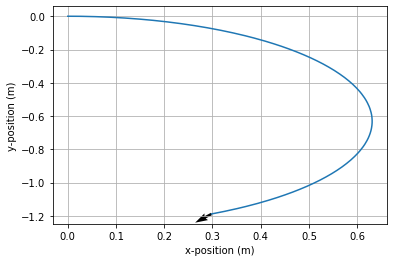

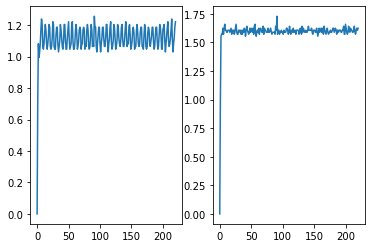

In [7]:
# plt.figure(figsize=(15,9))


# Plot robot data
plt.clf()
plt.figure()

plt.plot(np.array(poses)[:,0],np.array(poses)[:,1])
# plt.plot(x,y,'k',marker='+')
plt.quiver(x,y,0.1*np.cos(th),0.1*np.sin(th))
# plt.plot(goal_x,goal_y,'x',markersize=5)
# plt.quiver(goal_x,goal_y,0.1*np.cos(goal_th),0.1*np.sin(goal_th))
# plt.xlim(-1,1)
# plt.ylim(-1,1)
plt.xlabel('x-position (m)')
plt.ylabel('y-position (m)')
plt.grid()


plt.figure()
plt.subplot(1,2,1)
plt.plot(range(len(np.array(velocities)[:,0])),np.array(velocities)[:,0])
plt.subplot(1,2,2)
plt.plot(range(len(np.array(velocities)[:,1])),np.array(velocities)[:,1])


# plt.subplot(2,2,2)
# plt.plot(np.arange(i+1)*robot.dt,np.array(duty_cycle_commands))
# plt.xlabel('Time (s)')
# plt.ylabel('Duty cycle')
# plt.grid()

# plt.subplot(2,2,4)
# for i in range(300):
#     plt.plot(np.arange(i+1)*robot.dt,np.array(velocities))

#     plt.xlabel('Time (s)')
# plt.ylabel('Wheel $\omega$')
# plt.legend(['Left wheel', 'Right wheel'])
# plt.grid()


# display.clear_output(wait=True)
display.display(plt.gcf())



In [ ]:
# 
robot.set_motor_speed(0, 0)

In [ ]:

# # Set GPIO modes
# GPIO.setmode(GPIO.BCM)
# GPIO.setup(ML_IN1, GPIO.OUT)
# GPIO.setup(ML_IN2, GPIO.OUT)
# GPIO.setup(MR_IN3, GPIO.OUT)
# GPIO.setup(MR_IN4, GPIO.OUT)
# GPIO.setup(ML_ENA, GPIO.OUT)
# GPIO.setup(MR_ENB, GPIO.OUT)


# Main control loop

# robot.set_motor_speed(0, 0)
# # GPIO.cleanup()
    
# try:
#     while True:
#         # Example: Move forward at 0.5 m/s with no rotation
#         v_desired = 0.5
#         w_desired = 0.0
        
#         duty_cycle_l, duty_cycle_r = controller.drive(v_desired, w_desired, robot.wl, robot.wr)
#         x, y, th = robot.pose_update(duty_cycle_l, duty_cycle_r)
        
#         print(f"Position: ({x:.2f}, {y:.2f}), Orientation: {th:.2f}")
#         time.sleep(robot.dt)

# except KeyboardInterrupt:
#     print("Stopping robot")
#     robot.set_motor_speed(0, 0)
#     GPIO.cleanup()

